In [7]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
from scipy import interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable

#from scipy.ndimage import gaussian_filter1d
import sys

import qgm
from qgm import image, parameter, filter, data, fitting, function

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

In [3]:
TriLatticeDepth_meshgrid = np.load('TriLatticeDepth_meshgrid.npy')
LSfrequency_meshgrid = np.load('LSfrequency_meshgrid.npy')
visibility_array = np.load('visibility.npy')
center_array = np.load('center.npy')
# sd_visibility_array = np.load('sd_visibility.npy')
# sd_center_array = np.load('sd_center.npy')

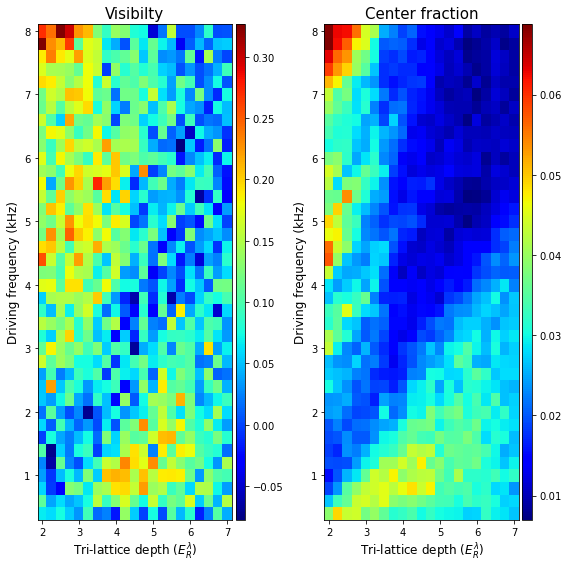

In [6]:
fig =plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(1,2,1)
mappable = ax1.pcolormesh(TriLatticeDepth_meshgrid,LSfrequency_meshgrid,visibility_array, cmap='jet', shading = "auto")
ax1.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax1.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax1.set_title('Visibilty', fontsize=15)
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"", fontsize=15)

ax2 = fig.add_subplot(1,2,2)
mappable = ax2.pcolormesh(TriLatticeDepth_meshgrid,LSfrequency_meshgrid,center_array, cmap='jet', shading = "auto")
ax2.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax2.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax2.set_title('Center fraction', fontsize=15)
divider2 = make_axes_locatable(ax2)
ax_cb2 = divider2.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb2)
pp.ax.set_title(r"", fontsize=15)

plt.tight_layout()

In [18]:
f_visibility = interpolate.interp2d(TriLatticeDepth_meshgrid[0], LSfrequency_meshgrid[:,0], visibility_array, kind='cubic')
f_center = interpolate.interp2d(TriLatticeDepth_meshgrid[0], LSfrequency_meshgrid[:,0], center_array, kind='cubic')
fine_TriLatticeDepth = np.linspace(np.min(TriLatticeDepth_meshgrid[0]), np.max(TriLatticeDepth_meshgrid[0]), 2*len(TriLatticeDepth_meshgrid[0]))
fine_LSfrequency = np.linspace(np.min(LSfrequency_meshgrid[:,0]), np.max(LSfrequency_meshgrid[:,0]), 2*len(LSfrequency_meshgrid[:,0]))
fine_visibility_array = f_visibility(fine_TriLatticeDepth, fine_LSfrequency)
fine_center_array = f_center(fine_TriLatticeDepth, fine_LSfrequency)
fine_TriLatticeDepth_meshgrid, fine_LSfrequency_meshgrid = np.meshgrid(fine_TriLatticeDepth, fine_LSfrequency)

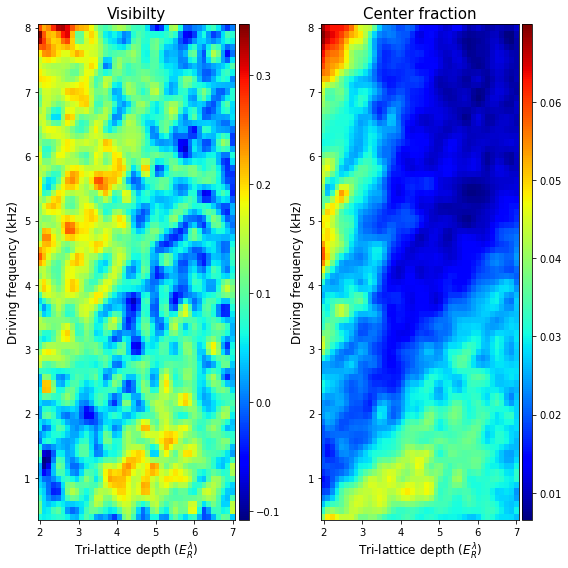

In [19]:
fig =plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(1,2,1)
mappable = ax1.pcolormesh(fine_TriLatticeDepth_meshgrid,fine_LSfrequency_meshgrid,fine_visibility_array, cmap='jet', shading = "auto")
ax1.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax1.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax1.set_title('Visibilty', fontsize=15)
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"", fontsize=15)

ax2 = fig.add_subplot(1,2,2)
mappable = ax2.pcolormesh(fine_TriLatticeDepth_meshgrid, fine_LSfrequency_meshgrid, fine_center_array, cmap='jet', shading = "auto")
ax2.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax2.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax2.set_title('Center fraction', fontsize=15)
divider2 = make_axes_locatable(ax2)
ax_cb2 = divider2.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb2)
pp.ax.set_title(r"", fontsize=15)

plt.tight_layout()

In [31]:
lam = 1 # Normalized wavelength
d = lam/2 # lattice constant

lambda_L = 1064*10**(-9) #wave lenght of triangular lattice beam [m] 
h_bar = 1.054571596*10**(-34) #Converted Plank const
mrb = 87*1.66053873*10**(-27) #Single atom mass of 87Yb
er = h_bar**2/(2*mrb)*(2*np.pi/lambda_L)**2 #Recoil energy of 532nm lattice
n = 8 # include (2n+1)^2 plane waves in calculation <=> calculate over (2n+1)^2 bands

#Quasimomentum list
q_list = [(0,0), (1/2,0), (2/3,1/3), (1/2,1/2)] #Gamma =(0,0), M = (1/2,0), K = (2/3,1/3), X = (1/2,1/2)

#Potential list
vmin = 2
vmax = 7
v_list = np.linspace(vmin,vmax,50) #Potential = 2ER - 6ER
upperLimitOfBandIndex = 4
gap_min = np.zeros((upperLimitOfBandIndex,len(v_list)))
gap_max = np.zeros((upperLimitOfBandIndex,len(v_list)))

In [41]:
Nsite=2*n+1
l_list = [(x, y) for x in np.linspace(-n, n, Nsite, dtype=np.int) for y in np.linspace(-n, n, Nsite, dtype=np.int)]
E = np.zeros([len(q_list), Nsite**2])
C = np.zeros([Nsite**2, len(q_list), Nsite**2])
H_tmp = np.zeros([Nsite**2, Nsite**2])

l_list_1 = np.array(l_list)[:, 0]
l_list_2 = np.array(l_list)[:, 1]
l2, l1 = np.meshgrid(l_list_1, l_list_1)
m2, m1 = np.meshgrid(l_list_2, l_list_2)

l_diffs_1 = l1 - l2
l_diffs_2 = m1 - m2
l_diffs = l_diffs_1 * l_diffs_2
condition_1 = (np.abs(l_diffs_1) == 1) * (m1 == m2)
condition_2 = (l1 == l2) * (np.abs(l_diffs_2) == 1)
condition_3 = (l_diffs == 1)

for i_v, v in enumerate(v_list):
    H_tmp = np.zeros([Nsite**2, Nsite**2])
#     H_tmp[condition_1 == 1] = 0.1
    H_tmp[condition_1 == 1] = -v/2
    H_tmp[condition_2 == 1] += -v/2
    H_tmp[condition_3 == 1] += -v/2
    for i_q, q in enumerate(q_list):
        H = np.copy(H_tmp)
        K = 3 * ((q[0] - l1)**2 + (q[1] - m1)**2 - (q[0] - l2) * (q[1] - m2))
        H += ((l1 == l2) * (m1 == m2)) * K
        E0, P = np.linalg.eig(H)
        rearrangedEvalsVecs = sorted(zip(E0, P.T), key=lambda x: x[0].real, reverse=False)
        E[i_q, :], tmp = map(list, zip(*rearrangedEvalsVecs))
        #C[:, i_q, :] = np.array(tmp)
    for j in range(upperLimitOfBandIndex):
        gap_min[j][i_v] = np.min(E[:,j+1]-E[:,0])
        gap_max[j][i_v] = np.max(E[:,j+1]-E[:,0])

gap_min *= er/(2*np.pi*h_bar)*10**(-3) # unit conversion: [E_R] => [kHz]
gap_max *= er/(2*np.pi*h_bar)*10**(-3) 

<ipython-input-41-394e192bdf79>:31: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i_q, :], tmp = map(list, zip(*rearrangedEvalsVecs))


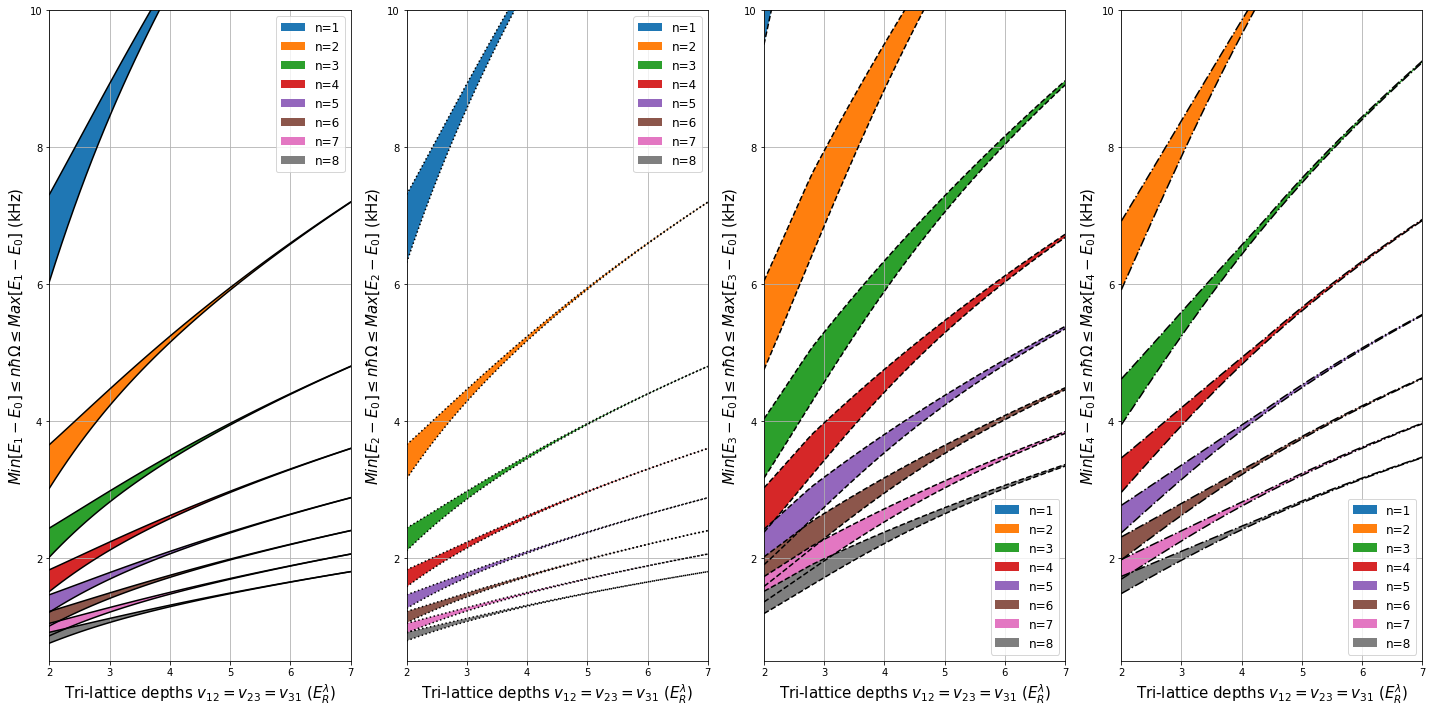

In [48]:
row_number = 1
column_number = upperLimitOfBandIndex

linestyle_list = ["solid","dotted","dashed","dashdot"]

fig, axes = plt.subplots(row_number, column_number, figsize = (20,10))
plt.subplots_adjust(wspace=0.2, hspace=0.35)
for i in range(row_number):
    for j in range(column_number):
        for n in range(1,9):
            axes[j].plot(v_list,gap_min[j]/n,v_list,gap_max[j]/n, linestyle = linestyle_list[j],color = "black")
            axes[j].fill_between(v_list,gap_min[j]/n,gap_max[j]/n,label="n="+str(n))
        axes[j].set_xlabel(r"Tri-lattice depths $v_{12} = v_{23} = v_{31}$ $(E_R^{\lambda})$", fontsize=15)
        axes[j].set_ylabel(r"$Min[E_{%d}-E_0] \leq n \hbar \Omega \leq Max[E_{%d}-E_0]$ (kHz)"%(j+1, j+1), fontsize=15)
        axes[j].set_xlim([vmin,vmax])
        axes[j].set_ylim([0.5,10])
        axes[j].legend(fontsize = 12)
        axes[j].grid()
plt.tight_layout()

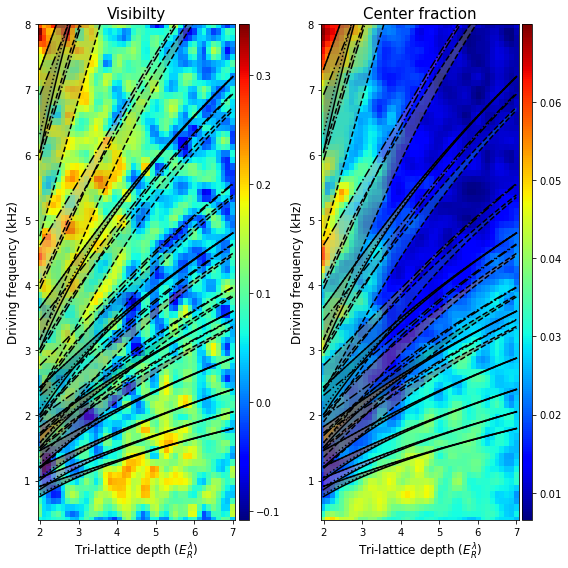

In [56]:
fig =plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(1,2,1)
mappable = ax1.pcolormesh(fine_TriLatticeDepth_meshgrid,fine_LSfrequency_meshgrid,fine_visibility_array, cmap='jet', shading = "auto")
ax1.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax1.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax1.set_title('Visibilty', fontsize=15)
divider1 = make_axes_locatable(ax1)
ax_cb1 = divider1.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb1)
pp.ax.set_title(r"", fontsize=15)
for j in range(column_number):
        for n in range(1,9):
            ax1.plot(v_list,gap_min[j]/n,v_list,gap_max[j]/n, linestyle = linestyle_list[j],color = "black")
            ax1.fill_between(v_list,gap_min[j]/n,gap_max[j]/n,alpha =0.3,label="n="+str(n))
ax1.set_ylim(np.min(LSfrequency_meshgrid[:,0]), np.max(LSfrequency_meshgrid[:,0]))

ax2 = fig.add_subplot(1,2,2)
mappable = ax2.pcolormesh(fine_TriLatticeDepth_meshgrid, fine_LSfrequency_meshgrid, fine_center_array, cmap='jet', shading = "auto")
ax2.set_xlabel(r'Tri-lattice depth ($E_R^\lambda$)',fontsize=12)
ax2.set_ylabel('Driving frequency (kHz)',fontsize=12)
ax2.set_title('Center fraction', fontsize=15)
divider2 = make_axes_locatable(ax2)
ax_cb2 = divider2.append_axes("right",size="5%",pad=0.05)
pp=fig.colorbar(mappable,cax=ax_cb2)
pp.ax.set_title(r"", fontsize=15)
for j in range(column_number):
        for n in range(1,9):
            ax2.plot(v_list,gap_min[j]/n,v_list,gap_max[j]/n, linestyle = linestyle_list[j],color = "black")
            ax2.fill_between(v_list,gap_min[j]/n,gap_max[j]/n,alpha =0.3,label="n="+str(n))
ax2.set_ylim(np.min(LSfrequency_meshgrid[:,0]), np.max(LSfrequency_meshgrid[:,0]))

plt.tight_layout()